Start: [0. 0.], Final parameters: [2.84155825 2.44503648], Final value: 21.9588
Start: [4. 4.], Final parameters: [2.26994027 2.05595655], Final value: 17.4965
Start: [-4. -4.], Final parameters: [-3.84888634 -3.83095968], Final value: 0.0008
Start: [ 2. -2.], Final parameters: [ 3.84555472 -0.3031991 ], Final value: 12.7590


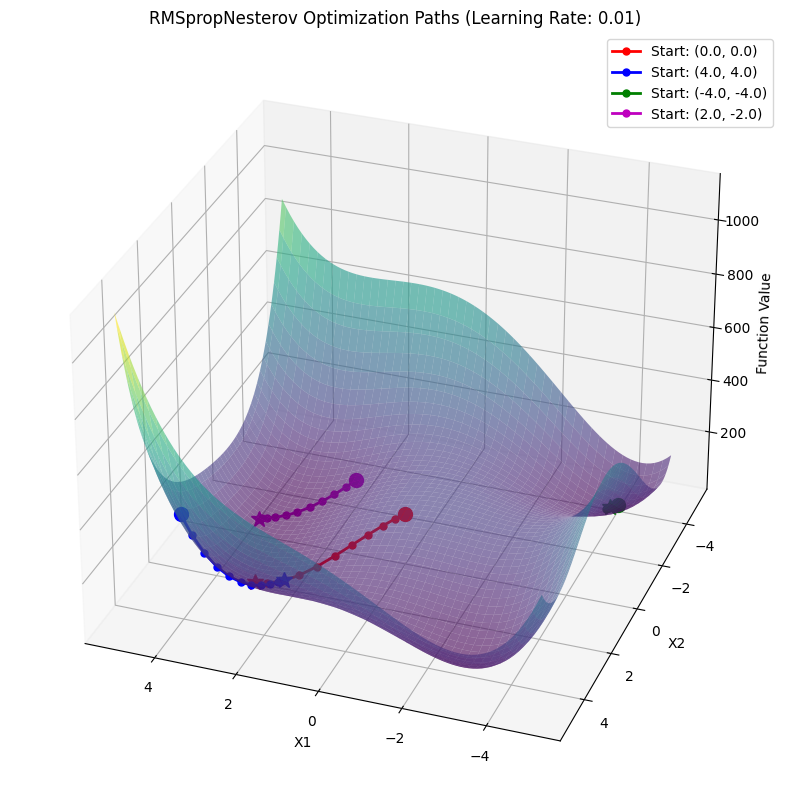

In [1]:
from typing import Callable, List, Tuple, Dict, Any
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class Optimizer:
    """کلاس پایه برای بهینه‌سازها"""
    def __init__(self, learning_rate: float):
        self.learning_rate = learning_rate

    def update(self, params: np.ndarray, grads: np.ndarray, state: Dict[str, Any]) -> Tuple[np.ndarray, Dict[str, Any]]:
        raise NotImplementedError("این متد باید در کلاس‌های فرزند پیاده‌سازی شود.")

class RMSpropNesterov(Optimizer):
    """بهینه‌ساز آر ام اس پروپ با نستروا (RMSprop with Nesterov Momentum)"""
    def __init__(self, learning_rate: float, decay_rate: float = 0.99, momentum: float = 0.9, epsilon: float = 1e-8):
        super().__init__(learning_rate)
        self.decay_rate = decay_rate
        self.momentum = momentum
        self.epsilon = epsilon

    def update(self, params: np.ndarray, grads: np.ndarray, state: Dict[str, Any]) -> Tuple[np.ndarray, Dict[str, Any]]:
        if 'square_grad' not in state:
            state['square_grad'] = np.zeros_like(params)
            state['velocity'] = np.zeros_like(params)
        
        state['square_grad'] = self.decay_rate * state['square_grad'] + (1 - self.decay_rate) * grads**2
        velocity_prev = state['velocity']
        state['velocity'] = self.momentum * velocity_prev - self.learning_rate / (np.sqrt(state['square_grad']) + self.epsilon) * grads
        return params + self.momentum * state['velocity'] - self.learning_rate / (np.sqrt(state['square_grad']) + self.epsilon) * grads, state

def optimize(optimizer: Optimizer, initial_params: np.ndarray, grad_func: Callable, num_iterations: int) -> List[np.ndarray]:
    """اجرای فرآیند بهینه‌سازی"""
    params = initial_params
    state = {}
    trajectory = [params.copy()]
    
    for _ in range(num_iterations):
        grads = grad_func(params)
        params, state = optimizer.update(params, grads, state)
        trajectory.append(params.copy())
    
    return trajectory

# تعریف تابع هدف و گرادیان آن
def func(params: np.ndarray) -> float:
    x1, x2 = params
    return (x1**2 + x2 - 11)**2 + (2*x1 + x2**2 - 7)**2

def gradient_function(params: np.ndarray) -> np.ndarray:
    x1, x2 = params
    df_dx1 = 4 * x1 * (x1**2 + x2 - 11) + 4 * (2*x1 + x2**2 - 7)
    df_dx2 = 2 * (x1**2 + x2 - 11) + 4 * x2 * (2*x1 + x2**2 - 7)
    return np.array([df_dx1, df_dx2])

# رسم مسیر بهینه‌سازی در فضای سه‌بعدی
def plot_3d_trajectory(func: Callable, trajectories: List[List[np.ndarray]], initial_points: List[np.ndarray], learning_rate: float):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # تولید داده‌های سطح تابع
    x1 = np.linspace(-5, 5, 100)
    x2 = np.linspace(-5, 5, 100)
    X1, X2 = np.meshgrid(x1, x2)
    Z = func(np.array([X1, X2]))
    
    # رسم سطح تابع
    ax.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.6)
    
    # رسم مسیرهای بهینه‌سازی برای نقاط شروع مختلف
    colors = ['r', 'b', 'g', 'm']
    for i, (trajectory, init_point) in enumerate(zip(trajectories, initial_points)):
        trajectory = np.array(trajectory)
        x1_traj = trajectory[:, 0]
        x2_traj = trajectory[:, 1]
        z_traj = func(trajectory.T)
        
        # رسم مسیر
        ax.plot(x1_traj, x2_traj, z_traj, f'{colors[i]}o-', label=f'Start: ({init_point[0]}, {init_point[1]})', linewidth=2, markersize=5)
        ax.plot([x1_traj[0]], [x2_traj[0]], [z_traj[0]], f'{colors[i]}o', markersize=10)  # نقطه شروع
        ax.plot([x1_traj[-1]], [x2_traj[-1]], [z_traj[-1]], f'{colors[i]}*', markersize=12)  # نقطه پایان
    
    # تنظیمات نمودار
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Function Value')
    ax.set_title(f'RMSpropNesterov Optimization Paths (Learning Rate: {learning_rate})')
    ax.legend()
    ax.view_init(30, 110)  # تنظیم زاویه دید
    
    plt.show()

# اجرای بهینه‌سازی با نقاط شروع مختلف
if __name__ == "__main__":
    learning_rate = 0.01  # نرخ یادگیری ثابت
    num_iterations = 10   # تعداد تکرارها
    
    # نقاط شروع مختلف
    initial_points = [
        np.array([0.0, 0.0]),
        np.array([4.0, 4.0]),
        np.array([-4.0, -4.0]),
        np.array([2.0, -2.0])
    ]
    
    optimizer = RMSpropNesterov(learning_rate)
    trajectories = []
    
    # بهینه‌سازی برای هر نقطه شروع
    for init_point in initial_points:
        trajectory = optimize(optimizer, init_point, gradient_function, num_iterations)
        trajectories.append(trajectory)
        print(f"Start: {init_point}, Final parameters: {trajectory[-1]}, Final value: {func(trajectory[-1]):.4f}")
    
    # رسم مسیرها
    plot_3d_trajectory(func, trajectories, initial_points, learning_rate)